In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import *
from sklearn.metrics import *
import matplotlib.pyplot as plt

# Load data 
raw_df = pd.read_csv('data/block-groups_pa.csv')

# Limit to Philadelphia and 2002-2016
raw_df = raw_df[raw_df['parent-location'] == 'Philadelphia County, Pennsylvania']
raw_df = raw_df[raw_df['year'] >= 2002]

# Create evictions_t-1 feature  
evictions = raw_df[['GEOID', 'year', 'evictions']]
evictions_wide = evictions.pivot(index='GEOID', columns='year', values='evictions')
merged_df = pd.merge(evictions, evictions_wide, left_on='GEOID', right_index=True)
for year in range(2003, 2017): 
    previous = year - 1 
    merged_df.loc[merged_df['year'] == year, 'evictions_t-1'] = merged_df[previous]
df = merged_df[['GEOID', 'year', 'evictions', 'evictions_t-1']]
df = df[df['year'] > 2002]

# Create binary target 
df['evictions_over10'] = np.where(df['evictions'] > 10, 1, 0)

# Split data 
def single_split(df, target_col, feature_cols, year): 
    df['train'] = np.where(df['year'] < year, 1, 0)
    df['test'] = np.where(df['year'] == year, 1, 0)
    X_train = df.loc[df['train']==1, feature_cols]
    X_test = df.loc[df['test']==1, feature_cols]
    y_train = df.loc[df['train']==1, target_col]
    y_test = df.loc[df['test']==1, target_col]
    return X_train, X_test, y_train, y_test 

In [5]:
# LogReg classifier
X_train, X_test, y_train, y_test = single_split(df, 'evictions_over10', ['evictions_t-1'], 2016)
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
pred_scores = model.predict_proba(X_test)
pred_labels = [1 if x[1] > 0.5 else 0 for x in pred_scores]

# Evaluate
accuracy_score(y_test, pred_labels)

0.8577844311377245

,evictions,predicted,evictions_t-1
120937,10.0,9.019297,9.0
120954,6.0,3.968618,3.0
120971,8.0,9.019297,9.0
120988,3.0,1.443278,0.0
121005,11.0,5.652178,5.0
121022,11.0,21.645996,24.0
121039,2.0,3.126838,2.0
121056,10.0,12.386417,13.0
121073,15.0,19.120656,21.0
121090,4.0,4.810398,4.0


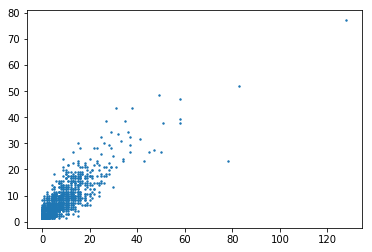

In [6]:
# Linear regression 
X_train, X_test, y_train, y_test = single_split(df, 'evictions', ['evictions_t-1'], 2016)
model = LinearRegression().fit(X_train, y_train)
y_preds = model.predict(X_test)

# Evaluate
mean_squared_error(y_test, y_preds)
r2_score(y_test, y_preds)
plt.scatter(y_test, y_preds, s=2)

# Results 
results = pd.merge(pd.DataFrame({'evictions': y_test, 'predicted': y_preds}), X_test, left_index=True, right_index=True)
results[:20]
